# Valuación de opciones Americanas

## 1. Recorderis de valuación usando simulación...

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    if freq == None:
        freq = 'd'
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [3]:
closes = get_closes(['AAPL'], '2017-01-01')
closes_appl = closes.loc[:,'AAPL']
closes_appl

Date
2017-01-03    112.621
2017-01-04    112.495
2017-01-05    113.067
2017-01-06    114.327
2017-01-09    115.375
               ...   
2018-11-06    203.061
2018-11-07    209.220
2018-11-08    208.490
2018-11-09    204.470
2018-11-12    195.785
Name: AAPL, Length: 470, dtype: float64

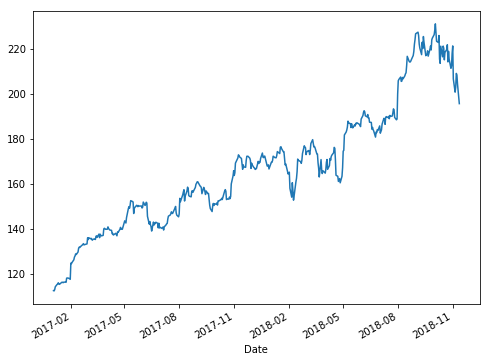

In [4]:
closes_appl.plot(figsize=(8,6))

In [5]:
ret_appl = calc_daily_ret(closes_appl)

Con los datos anteriormente descargados de el activo `apple` podemos saber entonces los datos de interés tales como $\sigma$ y un valor adecuado de precio de ejercicio $K$, para la opción a valorar

In [7]:
mu = ret_appl.mean()   # valor medio de los rendimientos
sigma = ret_appl.std() # desviación estándar de los rendimientos
r = 0.0273/360         #  tasa libre de riesgo 
mu, sigma, r

(0.0011790815716144873, 0.013784852070043064, 7.583333333333334e-05)

## Método de valuación de opciones americanas

Para explicar los aspectos teóricos de este tipo de opciones, primero vamos a indrocir el algoritmo en detalle y posteriormente explicaremos los conceptos.

### Ejemplo:
Tome $S (0) = 10$, $r = 0.03$, $\sigma = 0.4$. Calcule el valor de una opción de venta estadounidense con precio de ejercicio $K = 12$ y vencimiento $T = 1$. Por simplicidad, suponga que la opción se puede ejercer en t = 1/3, 2/3 y 1.

**Solución:** Lo primero que debemos de realizar es generar 8 escenarios diferentes de simulación, suponiendo un modelo normal para los rendimientos, para poder saber el precio de ejercicio en los instantes  t = 1/3, 2/3 y 1. En la siguiente tabla se muestras dichos precios simulados:

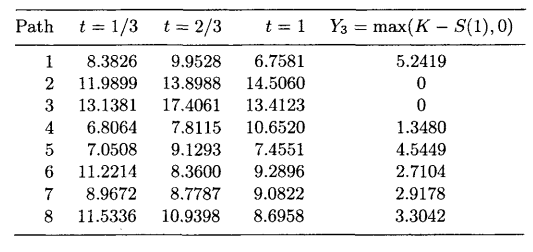


In [13]:
np.exp(-0.03*(1/3))*np.mean([5.2419,0,0,1.3480,4.5449,2.7104,2.9178,3.3042])

2.4834410029764133

Obteniendo la media de $Y_3$ da un estimado del valor del precio en ese instante **(Europea)**, el cual es `$2.4834`.
En el momento t = 2/3, el titular de la opción debe decidir si ejercer la opción de inmediato o continuar con la opción cuando la opción esté `in-the-money`.

El propietario de la opción debe de comparar el flujo de dinero en el inmediato ejercicio de la opción con el pago esperado de continuación dado el precio del activo en el momento t=2/3.

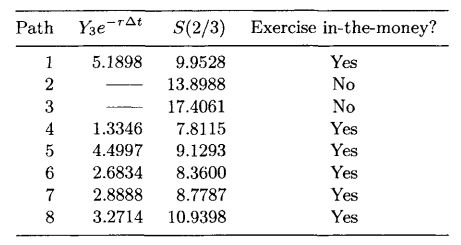

Observe que en este ejemplo el $\Delta t =1/3$. Modelamos la rentabilidad esperada de la continuación en el tiempo t = 2/3 como polinomios cuadráticos, $f_2 (S_t)$, de los valores de los activos en el tiempo t = 2/3. Por lo tanto para estimar los parámetros de los polinomios, usamos el método de mínimos cuadrados. De la siguiente forma:

$$ Y_3e^{-r\Delta t}=\hat a_0+\hat a_1 [S(2/3)]+\hat a_2 [S(2/3)]^2$$

**Mostrar en el tablero el método de mínimos cuadrados**.

### ¿ Cómo usar mínimos cuadrados?

In [17]:
# Datos en S(2/3) que estan 'in-the-money'
xdata = np.array([9.95,7.81,9.12,8.36,8.78,10.94])
# Se construye la matriz con los datos encontrados
A = np.zeros([len(xdata),3])
A[:,0] = np.ones(len(xdata)).T
A[:,1] = xdata.T
A[:,2] = (xdata**2).T
# Se traen al tiempo presente los valores encontrados 
# en el tiempo t=1 -> Y3
ydata = np.array([5.19,1.34,4.5,2.68,2.88,3.27])
# Se realiza la estimación de mínimos cuadrados
par = np.dot(np.linalg.pinv(A),ydata)
par


array([-82.31646411,  17.73449288,  -0.90407545])

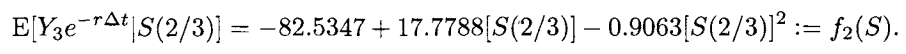

Con esta estimación de esta función esperada, podríamos comparar el valor del precio de ejercicio inmediato, $K-S(2/3)$ y el valor traído al presente de $Y_3$ como sigue:
$$
Y_2 =
\begin{cases}
    K-S(2/3), & \text{if } K-S(2/3)\geq f_2(S(2/3)) \\
    e^{-r\Delta t}Y_3, & \text{Otherwise}
\end{cases}
$$

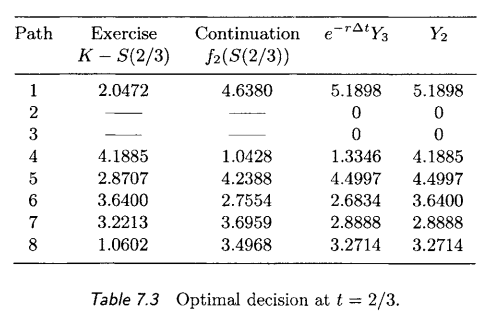

Nuevamente repetimos el procedimiento anterior, pero en este caso para t=1/3. Si utilizamos la siguiente tabla
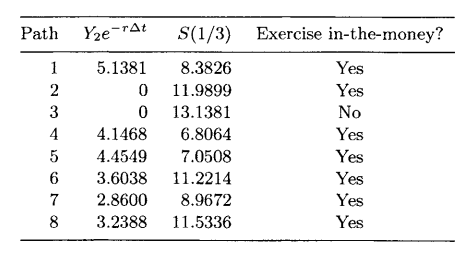

Podemos estimar por mínimos cuadrados el valor de la media en t=1/3, arrojando la siguiente función:

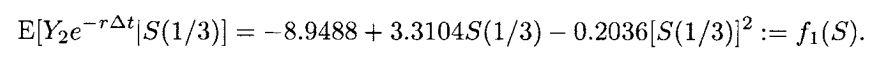

Nuevamente para obtener $Y_1$, calculamos la decisión óptima:
$$
Y_1 =
\begin{cases}
    K-S(1/3), & \text{if } K-S(1/3)\geq f_1(S(1/3)) \\
    e^{-r\Delta t}Y_2, & \text{Otherwise}
\end{cases}
$$

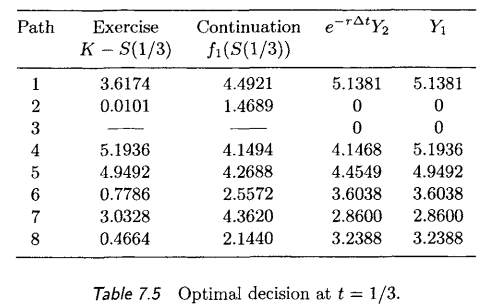



In [18]:
print('Valor prima Americana \n',np.exp(-0.03/3)*np.mean([5.1381,0,0,5.1936,4.9492,3.6038,2.86,3.2388]))

Valor prima Americana 
 3.0918637526840427


Finalmente, el precio actual de la opción  estadounidense se estima por el promedio
de $e^{-r\Delta t}Y_1$, es decir, `$ 3.0919`, que es más alto que el precio de opción europeo `$ 2.4834`.

> **Tomado de:** Simulation techniques in financial risk management, Ngail Hang Chan and Hoi Ying Wong,2015.

Teniendo los conceptos prácticos anteriomente ilustrados, podemos ahora analizar la aproximación realizada por mínimos cuadrados.

## Aproximación por mínimos cuadrados

Considere una opción de venta estadounidense con derechos de ejercicio en $t_1 <. . . <t_n= T$.
Para simplificar las cosas, suponemos que $t_{j+1}- t_j = \Delta t$ para j = 1,2 ,. .., n- 1. Dado un ruta de muestra del precio del activo subyacente, $\{S (t_1), S (t_2), ..., S (t_n),\} $ estudiamos posibles pagos recibidos por el titular de la opción en cada uno de los momentos de los puntos de tiempos de ejercicio.

** Pago en el tiempo de cierre $t=t_n=T$**
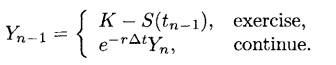

** Pago en el tiempo $t=t_j$**
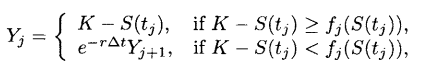

donde $f_j(S(t_j))$ es la esperanza condicional en $t_j$, es decir:
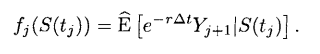

Recuerde que esta esperanza condicional, es estimada usando mínimos cuadrados, y por practicidad se va a aproximar esta función a una función polinomial de grado 2.

Los coeficientes presentes en esta función, son estimados usando mínimos cuadrados para la regresión cuadrática:

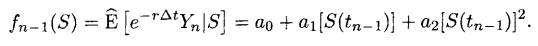

**Nota:** Observe que esta regresión, sólo es realizada, en los escenarios `in-the-money`, es decir que valores que no entren `in-the-money`, serán descartados para el análisis.

La valoración neutral al riesgo nos permite valorar el valor de American put, $P_A (0, S)$, como:
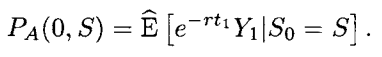

Por lo tanto, un algoritmo de simulación típico genera N escenarios de muestreo, donde cada uno sigue el algoritmo para obtener $\{Y_1^{(1)},\cdots, Y_1^{(N)}\}$. Por lo tanto el valor del put para opciones americanas puede ser estimado por:
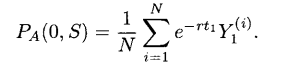

## *Nota*: A la hora de actualizar esta clase con Gitkraken también actualizan un documento en PDF donde econtrarán detalles adicionales acerca de las opciones americanas

### 1.1 Modelo normal de rendimientos

In [46]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    T = 1
    nu = mu-(sigma**2)/2
    
    DeltaT = T/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    
    #for i in range(NbStep):
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep)
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt)
    t = np.arange(0,1+DeltaT,DeltaT)

    return St.T,t

In [47]:
r_ex = 0.03   # Anual
sigma_ex = .4 # Anual
S0 = 10       # Precio inicial
K = 12        # Strike price
NbTraj = 8
NbStep = 3
# Resolvemos la ecuación de black scholes para obtener los precios cada cuatro meses
St,t = BSprices(r_ex,sigma_ex,S0,NbTraj,NbStep)
St.shape,t.shape

((4, 8), (4,))

In [49]:
col = ['t=%2.2f' %i for i in t]
prices = pd.DataFrame(St.T,index=np.arange(NbTraj),columns=col)
prices

,t=0.00,t=0.33,t=0.67,t=1.00
0,10.0,10.898,7.646,10.333
1,10.0,9.244,9.694,13.460
2,10.0,7.539,9.422,4.365
3,10.0,9.952,7.575,6.836
4,10.0,11.351,9.035,10.151
5,10.0,7.639,8.566,8.841
6,10.0,9.077,10.939,14.121
7,10.0,7.674,11.117,10.973


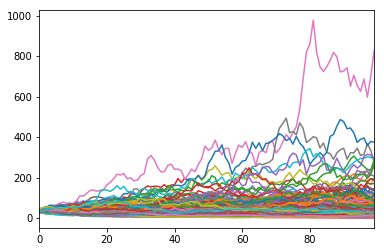

In [31]:
K = 40
sigma = 0.1
r = 0.06/360
S0 = 36
ndays = 100
nscen = 200
dates = np.arange(0,ndays,1)
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.plot(legend=False);

In [ ]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen]))},index=dates)

# put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)

In [ ]:
put.iloc[-1]

In [ ]:
# Intervalos de confianza
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

## Examen.

Realizar la valuación de opciones 'PUT' y 'CALL' para las opciones americanas siguiendo  los lineamientos ilustrados en clase. Además se deberá tomar como base el documentos llamado `American options`, para complementar lo visto en clase.
1. Realizar la valuación tomando los siguientes parámetros: $S(0)=36,r=0.06 (anual), \sigma =0.1, K=40$.

Deben de comparar los resultados de valuación usando el siguiente número de escenarios y número de días a simular:

- Número de escenarios: [1000,10000,100000]
- Para cada número de escenarios dado anteriomente, se deben de realizar la valuación para [50,100,150] días respectivamente.

Todos los resultados de la valuación deben de ser reportados en una tabla de pandas, similar a como lo hicimos en clases anteriores.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Z.
</footer>